# Filtragem de imagens e contornos com OpenCV

**Atenção**: Rode este notebook com `jupyter notebook` e não `jupyter lab`. A parte interativa requer que seja específico

Bibliografia: 

[Cap.5 - Computer Vision. Shapiro](https://courses.cs.washington.edu/courses/cse576/book/ch5.pdf)

[Cap.3 - Digital Image Processing. Gonzales / Woods](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/Digital_Image_Processing_2ndEd.pdf)

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
import sys
import math
print ("OpenCV Version : %s " % cv2.__version__)

import auxiliar as aux

from ipywidgets import widgets, interact, interactive, FloatSlider, IntSlider

OpenCV Version : 4.6.0 


# Usando OpenCV para facilitar nossa vida

Na última APS programamos diretamente duas operações comuns em imagens:

1. *limiarização*: transforma uma imagem níveis de cinza em uma máscara binária. Útil para segmentar a imagem
2. *ajuste de constraste*: "estica" o histograma da imagem, melhorando o constraste entre regiões da imagem.

O OpenCV já tem funções que fazem essas operações e, agora que já entendemos o que elas fazem, podemos usá-las para deixar nosso código mais compacto.

# Ajuste de contraste

A função `cv2.equaliseHist` faz o ajuste de constraste em uma imagem. Veja [na documentação do OpenCV](https://docs.opencv.org/4.6.0/d5/daf/tutorial_py_histogram_equalization.html) mais detalhes sobre seu funcionamento.

In [2]:
rintin = cv2.imread("img/RinTinTin.jpg", cv2.IMREAD_GRAYSCALE)

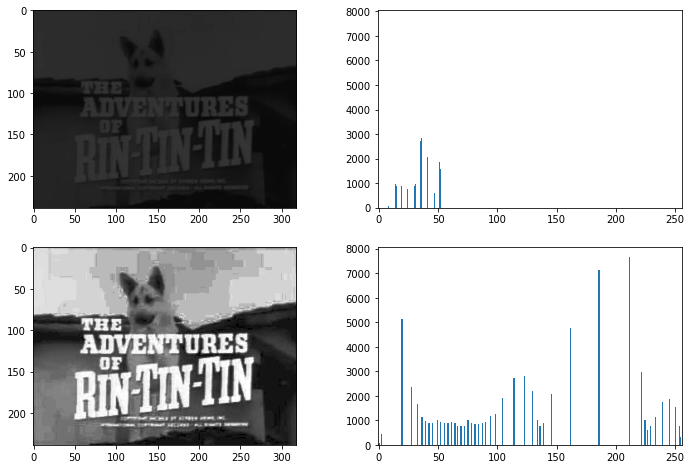

In [3]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(rintin, cmap="gray", vmin=0, vmax=255)
plt.subplot(222)
plt.hist(rintin.flatten(), bins=256)
plt.xlim([-1,256])


rintin_eq = cv2.equalizeHist(rintin)
plt.subplot(223)
plt.imshow(rintin_eq, cmap='gray')
plt.subplot(224)
plt.hist(rintin_eq.flatten(), bins=256)
plt.xlim([-1,256])

plt.show()


## Limiarização

A função `cv2.threshold` realiza a operação de limiarização. Veja [na documentação do OpenCV](https://docs.opencv.org/4.6.0/d7/d4d/tutorial_py_thresholding.html) mais detalhes sobre ela. 

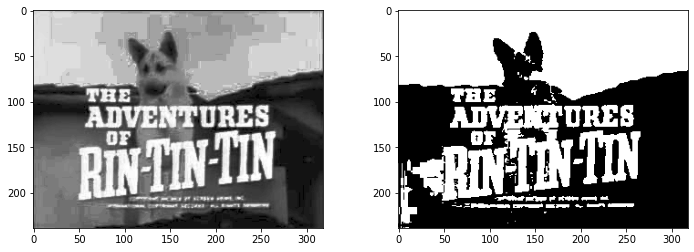

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(rintin_eq, cmap="gray", vmin=0, vmax=255)

plt.subplot(122)
ret, rintin_lim = cv2.threshold(rintin_eq, 127, 255, cv2.THRESH_BINARY)
plt.imshow(rintin_lim, cmap='gray')
plt.show()

# Detecção de cores com HSV

O espaço de cores HSV facilita nossa vida para fazer segmentação por cores

![](https://upload.wikimedia.org/wikipedia/commons/8/8f/HSV_cylinder.jpg)

**Fonte**: [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/8/8f/HSV_cylinder.jpg) 

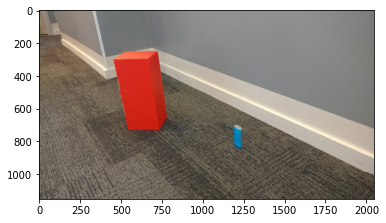

In [5]:
img_color = cv2.imread("img/hall_box_battery1.jpg")
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
plt.imshow(img_rgb)
plt.show()

In [6]:
colorpicker = widgets.ColorPicker(
    concise=False,
    description='Escolha uma cor',
    value='#ff0e00',
    disabled=False
)
colorpicker

ColorPicker(value='#ff0e00', description='Escolha uma cor')

In [7]:
hsv1, hsv2 = aux.ranges(colorpicker.value)
print(hsv1, hsv2)

[ 0 50 50] [ 10 255 255]


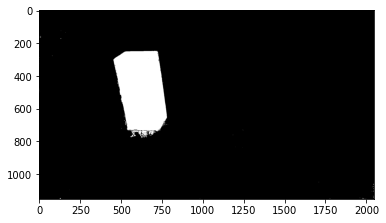

In [8]:
mask = cv2.inRange(img_hsv, hsv1, hsv2)
plt.imshow(mask, cmap="gray")
plt.show()

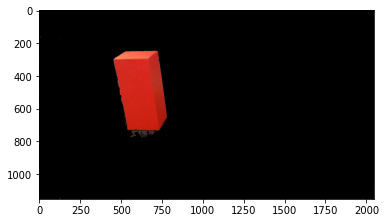

In [9]:
selecao = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
plt.imshow(selecao)
plt.show()

<div id="compconexos"></div>

## Componentes conexos e contornos

E se tivéssemos mais de um objeto vermelho na imagem? Como faríamos para identificá-los?

Fonte das imagens: [http://time.com/4299724/coca-cola-diet-coke-redesign/](http://time.com/4299724/coca-cola-diet-coke-redesign/)

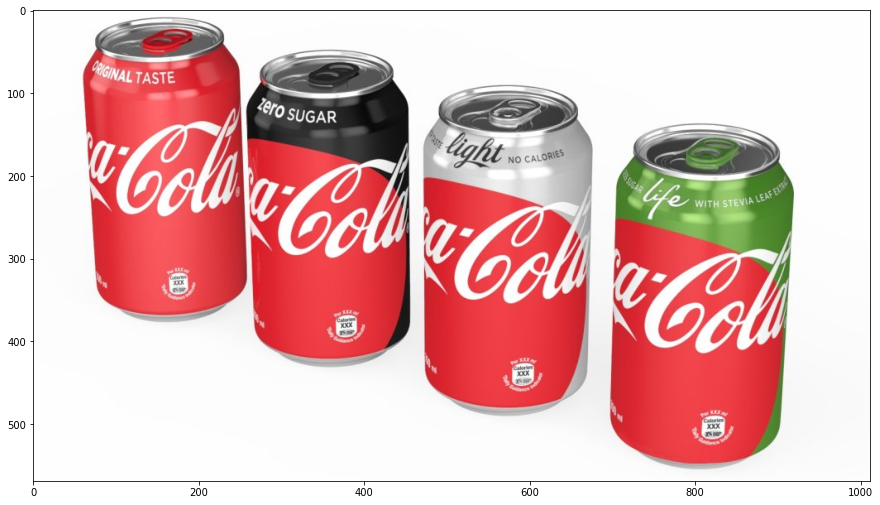

In [10]:
coke = cv2.imread("img/coke-cans.jpg")
coke_rgb= cv2.cvtColor(coke, cv2.COLOR_BGR2RGB)
coke_hsv= cv2.cvtColor(coke, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(15,10))
plt.imshow(coke_rgb)
plt.show()

Para detectar vermelho em HSV, não se esquecer de selecionar a faixa inferior e a superior do canal H

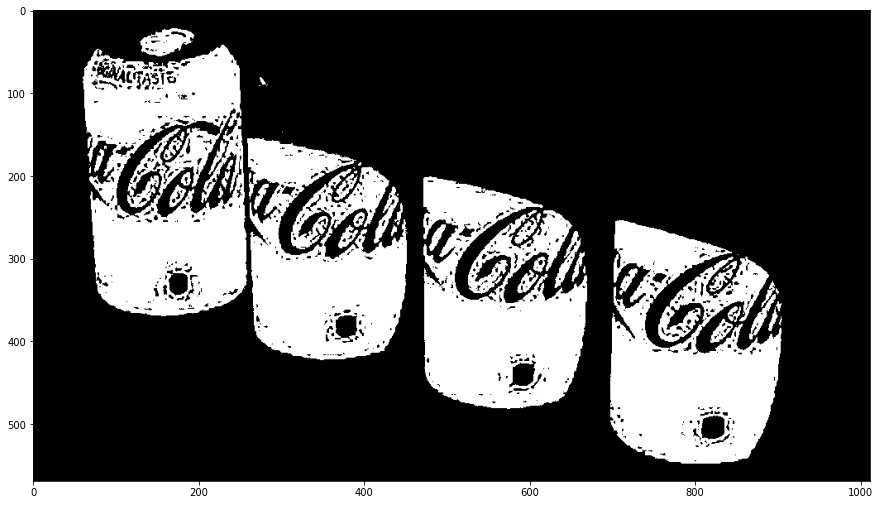

In [11]:
cor_menor1 = np.array([172, 50, 50])
cor_maior1 = np.array([180, 255, 255])
mask_coke1 = cv2.inRange(coke_hsv, cor_menor1, cor_maior1)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke1, cmap='gray')
plt.show()


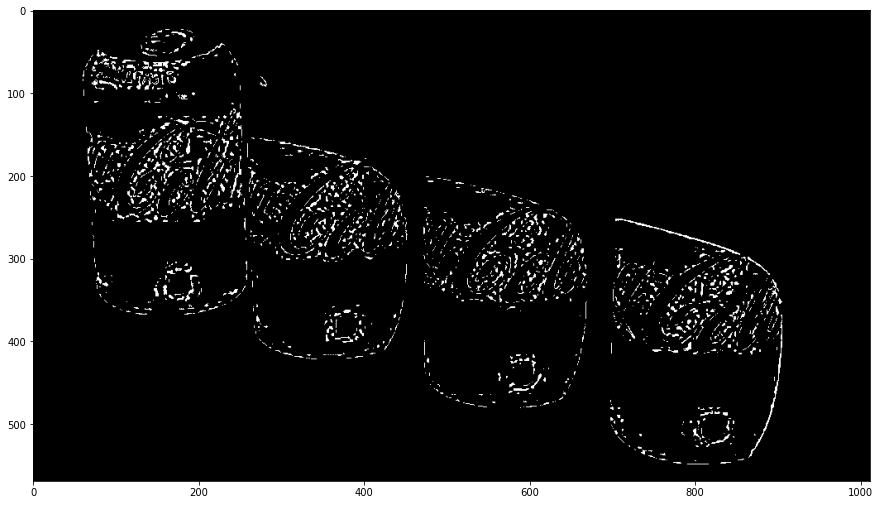

In [12]:
cor_menor2 = np.array([0, 50, 50])
cor_maior2 = np.array([8, 255, 255])
mask_coke2 = cv2.inRange(coke_hsv, cor_menor2, cor_maior2)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke2, cmap='gray')
plt.show()

In [13]:
# Juntando as máscaras
mask_coke = cv2.bitwise_or(mask_coke1, mask_coke2)

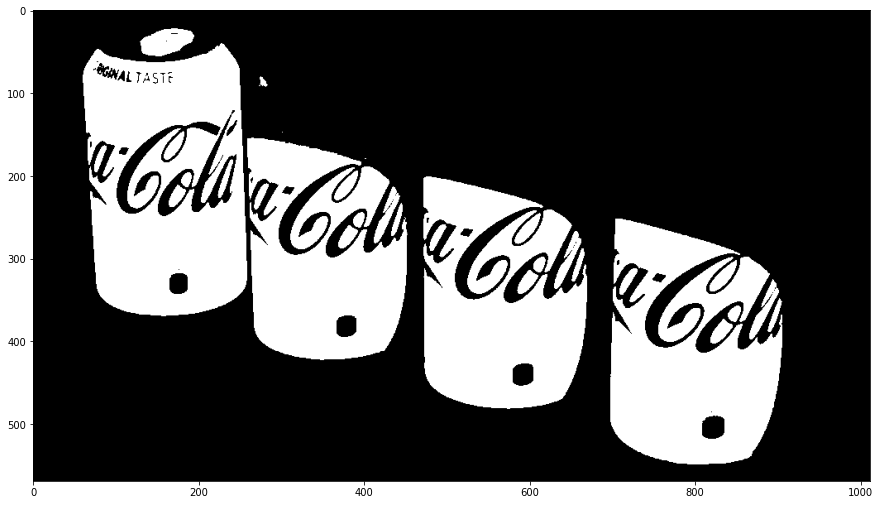

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(mask_coke, cmap="gray", vmin=0, vmax=255)
plt.show()

## Componentes conexos

Após a segmentação da imagem por mascaramento, podemos observar que os pixels de interesse podem formar um ou mais grupos conectados entre si, ou seja, conjuntos de pixels que se comunicam através de algum caminho que passa apenas por pixels de interesse (brancos)

![](img/retangulos.bmp) -> ![](img/retangulos_mask.bmp) -> ![](img/retangulos_ccomp.bmp)

No OpenCV, é possível encontrar componente conexos em imagens tons de cinza através da função `cv2.findContours()`. Ela considera pixels de valor maior do que 0 como pixels de interesse. 

Usamos a função da forma:

```
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
```
onde:
- `mask` é a imagem com a máscara binária
- `cv2.RETR_CCOMP` indica que queremos organizar os contornos em componentes conexos e buracos dentro deles
- `cv2.CHAIN_APPROX_NONE` indica que queremos armazenar todos os pontos do contorno
- `contours` é uma lista de contornos, contendo os pontos a ele pertencententes
- `hierarchy` é uma lista indicando a organização dos contornos em termos dos componentes e de seus buracos


Os componentes conexos são representados através de seus contornos internos, ou seja, dos pixels de cada componente conexo que são vizinhos a pixels de fundo. Para desenhar os contornos em uma imagem, usamos a função `cv2.drawContours()`, que usamos da forma:

```
cv2.drawContours(imagem, contours, indice, cor)
```
- `imagem` é a imagem colorida ou tons de cinza a receber o contorno
- `contours` é a lista de contornos obtida com `cv2.findContours()`
- `indice` é o índice do contorno dentro da lista a ser desenhado; se indice < 0 desenha todos os contornos
- `cor` é a cor do pixel a ser usada para desenhar o contorno   



In [15]:
contornos, arvore = cv2.findContours(mask_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
len(contornos)

111

In [16]:
contornos_img = coke_rgb.copy()
cv2.drawContours(contornos_img, contornos, -1, [0, 0, 255], 3);

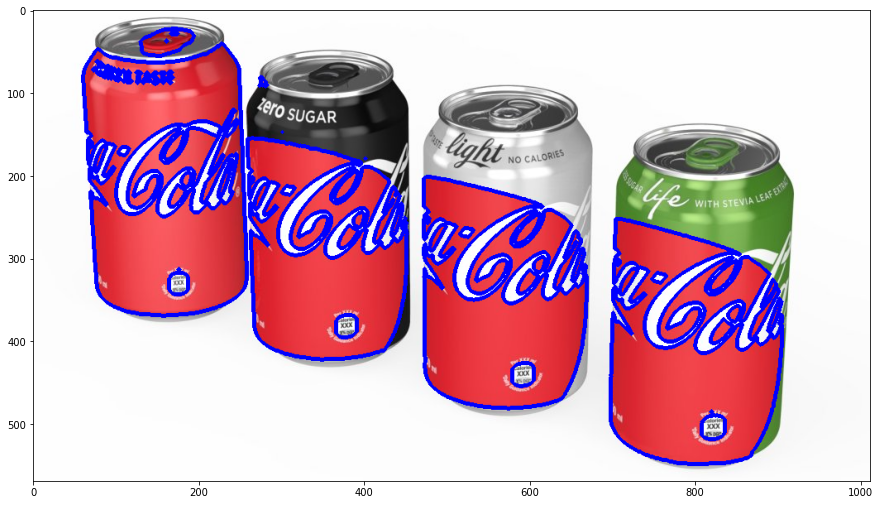

In [17]:
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

### Medidas dos contornos

A partir dos contornos, podemos tirar uma série de medidas como:
- **Área:** número de pixels petencentes ao contorno, calculada com `cv2.contourArea(contour)`
- **Centro de massa:** linha e coluna do centro de masssa do contorno

**Exemplo:** calcula o componente conexo de maior área e desenha seu contorno e o ponto do centro de massa 

#### Maior contorno

In [18]:
maior = None
maior_area = 0
for c in contornos:
    area = cv2.contourArea(c)
    if area > maior_area:
        maior_area = area
        maior = c

In [19]:
cv2.drawContours(contornos_img, [maior], -1, [0, 255, 255], 5);


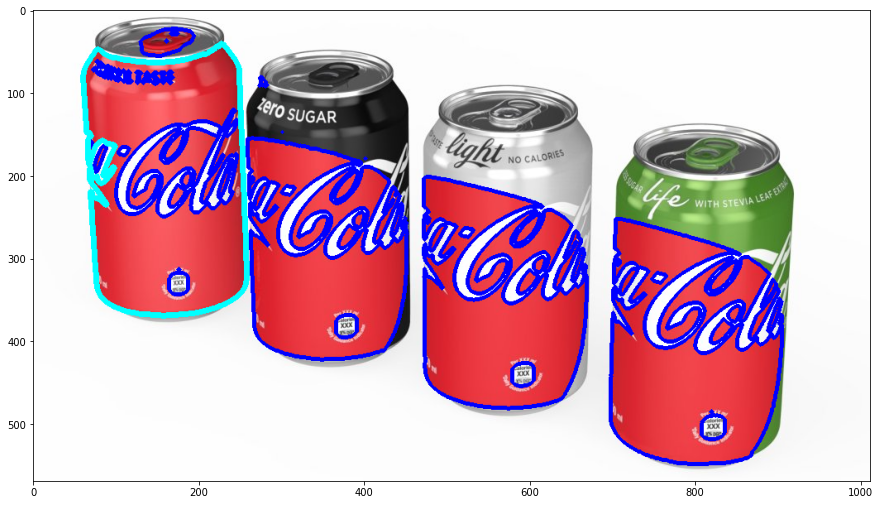

In [20]:
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

#### Centro de massa do contorno.

**Jeito 1** - mais preciso

In [21]:
def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,5)
    cv2.line(img,(x,y - size),(x, y + size),color,5)

In [22]:
""" Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
M = cv2.moments(maior)
# Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

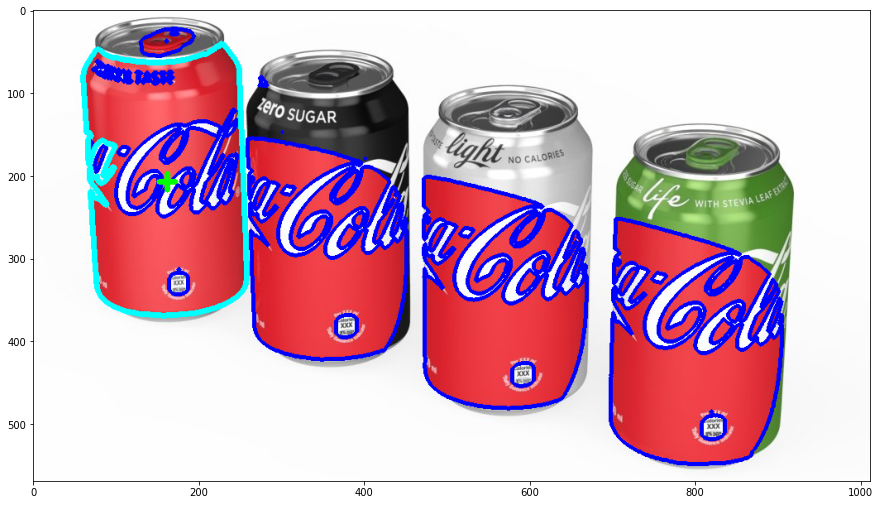

In [23]:
crosshair(contornos_img, (cX,cY), 10, (0,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

**Jeito 2** - aproximado

**ATENÇÃO:** essa técnica de calcular o centro de massa diretamente do contorno dá resultados melhores quando usado com contornos convexos e `cv2.CHAIN_APPROX_NONE`. Em outros casos, é melhor fazer como no jeito 1.

In [24]:
cX = int(maior[:,:,0].mean())
cY = int(maior[:,:,1].mean())

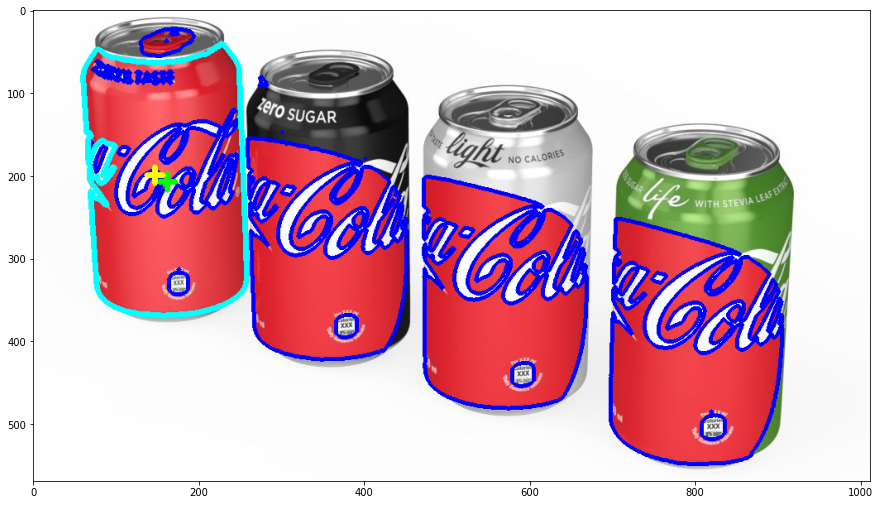

In [25]:
crosshair(contornos_img, (cX,cY), 10, (255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

## Prática

**Exercício 1**: ainda trabalhando com as imagens das latinhas, use seus conhecimentos de segmentação de imagens para obter uma máscara que tenha somente o contorno externo das 4 latinhas.

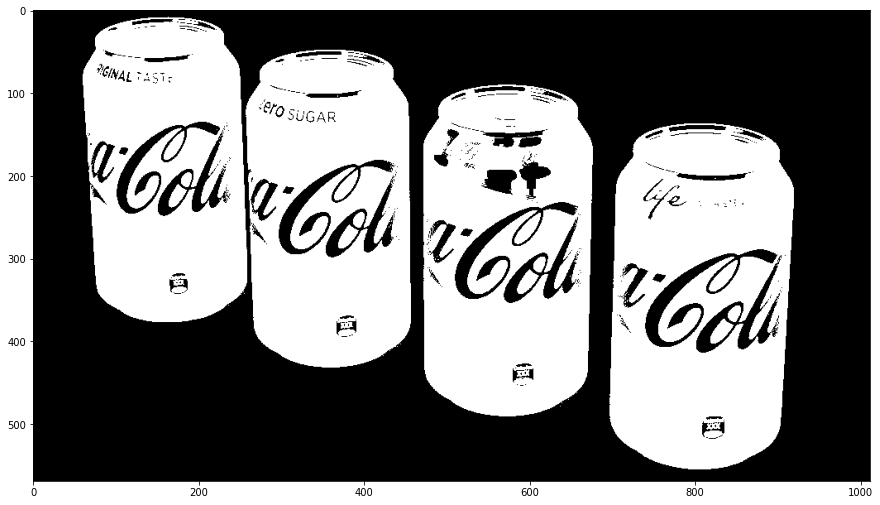

In [26]:
coke_gray= cv2.cvtColor(coke_rgb, cv2.COLOR_RGB2GRAY)
branco_menor = np.array([0])
branco_maior = np.array([230])
branco = cv2.inRange(coke_gray, branco_menor, branco_maior)

plt.figure(figsize=(15,10))
plt.imshow(branco, cmap="gray", vmin=0, vmax=255)
plt.show()

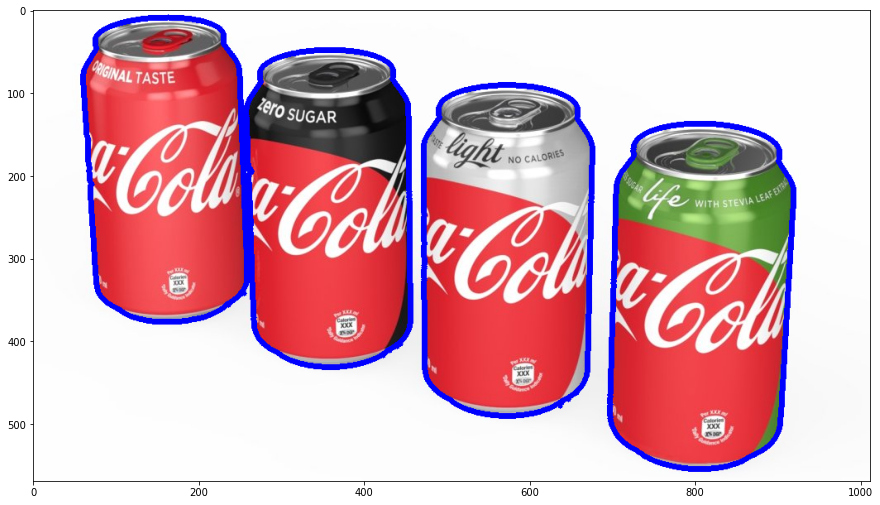

In [27]:
contornos, arvore = cv2.findContours(branco.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contornos_img_all = coke_rgb.copy()
cv2.drawContours(contornos_img_all, contornos, -1, [0, 0, 255], 5)

plt.figure(figsize=(15,10))
plt.imshow(contornos_img_all)
plt.show()

**Exercício 2**: usando código, faça uma função que filtra a máscara anterior e deixa somente as latinhas da Coca-cola Life (a que tem a parte verde no topo). **Dica**: use as funções de contornos para analisar cada latinha individualmente. Depois disso, veja se a latinha contém uma quantidade de pixels verdes "grande".

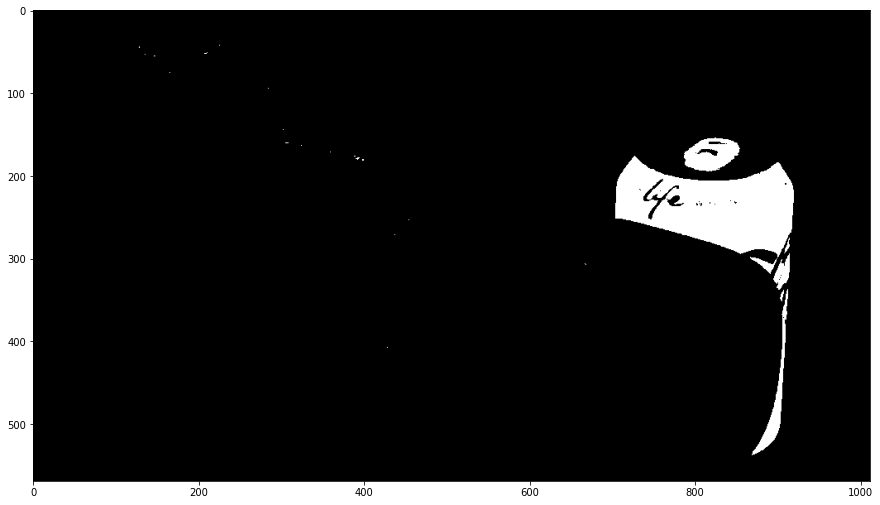

In [28]:
verde_menor = np.array([10,50,50])
verde_maior = np.array([150,255,255])
verde = cv2.inRange(coke_hsv, verde_menor, verde_maior)

plt.figure(figsize=(15,10))
plt.imshow(verde, cmap="gray", vmin=0, vmax=255)
plt.show()

In [29]:
# Separa os contornos das aulas
contornos_latas = []
for c in contornos:
    area = cv2.contourArea(c)
    if area > 1000:
        contornos_latas.append(c)

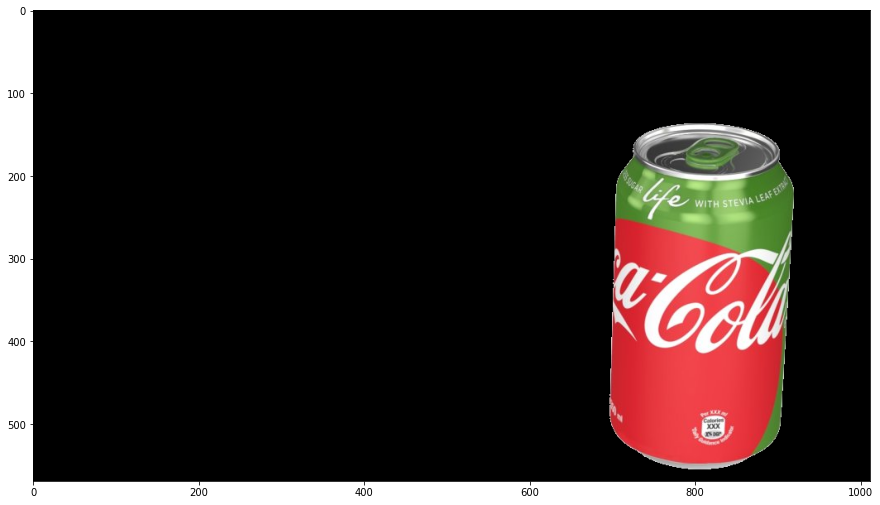

In [30]:
lata_verde = np.NaN
for i, contorno in enumerate(contornos_latas):
    mascara_lata = np.zeros_like(coke_gray)
    cv2.drawContours(mascara_lata, contornos_latas, i, [255, 0, 0], cv2.FILLED)
    lata = cv2.bitwise_and(mascara_lata, mascara_lata, mask=verde)

    if np.sum(lata) > 10000:
        lata_verde = cv2.bitwise_and(coke_rgb, coke_rgb, mask=mascara_lata)
        break
    
plt.figure(figsize=(15,10))
plt.imshow(lata_verde)
plt.show()


<div id="hough"></div>